# Analyzing coverage scheme among dbs

https://www.kaggle.com/ar2017/identifying-coverage-scheme-among-defensive-backs

# Note: 
This was part of my project last semestor for a machine learning and statistical pattern classification class. There were 2 other people in my group, and the goal of this project ended up being very unrealistic for the time constraints.

This notebook is really cluttered as a result, and a lot of the cells aren't even in the right order, as I was scrambling to get results for our report.

# Overview

The link above has the code I followed for feature generation, and creating the gmm.

The goal of this project was ultimately to compare how different defensive coverages performed against different NFL passing plays.

To do this, we analyzed a subset of plays from the data provided in the NFL big data bowl competition. For each play we analyzed, we grouped similar offenses together, and similar defenses together, and created a decision tree to see if there was any significant correlation between the two.

The goal of this notebook is to ultimately group similar defensive coverages together. To help with this, we generate new features that let us classify defensive backs (and linebackers, but not as well) as either man-to-man or zone. 

My part of the project was to create the defense classifier. To do so, I followed the code found here https://www.kaggle.com/ar2017/identifying-coverage-scheme-among-defensive-backs to generate new features from the provided data, and to be make a gaussian mixture model.

At the end of this notebook, I also was in the process of comparing different classification algorithms to see which one worked better, but finals and other projects got really busy and my group and I just used the gmm.

### imports

In [2]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
from ipywidgets import interact, fixed
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

In [3]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import animation
from matplotlib.animation import FFMpegWriter
pd.set_option('max_columns', 100)

In [4]:
import dateutil
from math import radians

In [5]:
#plotting imports
from mlxtend.plotting import scatterplotmatrix

## preparing the data
Note: actually just running this on week1 since 1,2, and 5 together still take a while
Note: just running this on weeks 1,2, and 5, running on more weeks was taking way too long

In [6]:
# *** just week1 for now
def setup_week_data():
    DATA_DIR = './data/raw'

    PLAY_DIR = DATA_DIR + '/plays.csv'
    WEEK_DIR = DATA_DIR + '/games.csv'

    plays = pd.read_csv(PLAY_DIR)
    week1 = pd.read_csv(DATA_DIR + '/week1.csv')
    week2 = pd.read_csv(DATA_DIR + '/week2.csv')
    week5 = pd.read_csv(DATA_DIR + '/week5.csv')

    week = pd.concat([week1, week2, week5], ignore_index=True)
    #week=week1
    #weekData = pd.read_csv(DATA_DIR + '/week1.csv')
    #week
    return week

The possible defense positions are: 
'SS', 'FS', 'MLB', 'CB', 'LB', 'OLB', 'ILB', 'DB', 'DL','NT', 'S', 'DE'
Using the features generated from 
https://www.kaggle.com/ar2017/identifying-coverage-scheme-among-defensive-backs ,
we'll try to classify the coverage of the defensive backs (SS, FS, S, CB) as man or zone, and we'll try to use it for linebackers too, but we aren't sure how well these features will work for linebackers.


In [7]:
# this gives an event to every row, instead of having "none". 
# the new events are: 'ball_snap', 'between_snap', 'after_thrown'

# week: a data frame from '.../week{i}.csv'
# returns: the dataframe with events all either 'ball_snap', 
# 'between_snap', 'pass_forward', or 'after_thrown'
def convert_events_cols(week):
    weekArray = np.array(week)
    previousEvent = 'ball_snap'
    for i, instance in enumerate(weekArray):
        event = instance[8]
        frameId = instance[13]
        if (previousEvent == 'ball_snap' and event != 'ball_snap') or frameId == 1:
            weekArray[i][8] = 'ball_snap'
            previousEvent = 'ball_snap'
        elif (event == 'ball_snap'):
            previousEvent = 'between_snap'
        elif (previousEvent == 'between_snap' and event != 'pass_forward'):
            weekArray[i][8] = 'between_snap'
            previousEvent = 'between_snap'
        elif (event == 'pass_forward'):
            weekArray[i][8] = 'after_thrown'
            previousEvent = 'after_thrown'
        elif (previousEvent == 'after_thrown' and frameId != 1):
            weekArray[i][8] = 'after_thrown'
            previousEvent = 'after_thrown'

    weekMod = pd.DataFrame(weekArray, columns=week.columns)
    week['event'] = weekMod['event']
    weekMod = week
    return weekMod

In [160]:
# weekMod = convert_events_cols(week)

## Now we have to generate the features

From the link:

In the paper, there are 11 features that can be estimated at different points throughout the play that characterize the type of coverage scheme:

varX: Variance in the x coordinate <br>
varY: Variance in the y coordinate <br>
varS: Variance in the speed <br>
offVar: Variance in the distance from the nearest offensive player at every frame <br>
defVar: Variance in the distance from the nearest defensive player at every frame <br>
offMean: Mean distance from the nearest offensive player at every frame <br>
defMean: Mean distance from the nearest defensive player at every frame <br>
offDirVar: Variance in the difference in de- grees of the direction of motion between the player and the nearest offensive player <br>
offDirMean: Mean difference in degrees of the direction of motion between the player and the nearest offensive player <br>
ratMean: Mean ratio of the distance to the nearest offensive player and the distance from the nearest offensive player to the nearest defensive player <br>
ratVar: Variance of the ratio of the distance to the nearest offensive player and the distance from the nearest offensive player to the nearest defensive player <br><br>
These features are specific for defensive backs. But, I'll generate features for all players (defensive and offensive) to use for further analysis. So, a bit of generalization is required to do that. For instance, offVar is basically the variance in the distance from the nearest opponent player and defVar is the variance in the distance from the nearest team mate. So, I change the name of some features a little bit:

varX: Variance in the x coordinate <br>
varY: Variance in the y coordinate <br>
varS: Variance in the speed <br>
oppVar: Variance in the distance from the nearest opponent player at every frame <br>
mateVar: Variance in the distance from the nearest team mate at every frame <br>
oppMean: Mean distance from the nearest opponent player at every frame <br>
mateMean: Mean distance from the nearest team mate at every frame <br>
oppDirVar: Variance in the difference in degrees of the direction of motion between the player and the nearest opponent player <br>
oppDirMean: Mean difference in degrees of the direction of motion between the player and the nearest opponent player <br>
ratMean: Mean ratio of the distance to the nearest opponent player and the distance from the nearest opponent player to the nearest team mate <br>
ratVar: Variance of the ratio of the distance to the nearest opponent  player and the distance from the nearest opponent player to the nearest team mate

#### var (x,y) coord and speed

In [8]:
# weekMod - a dataframe from '../week{i}.csv'
def var_x_y_speed(weekMod):
    #print(type(weekMod))
    varX = weekMod.groupby(['gameId', 'playId', 'event', 'nflId'])['x'].agg(['var']).reset_index().rename(columns={"var": "varX"})
    varY = weekMod.groupby(['gameId', 'playId', 'event', 'nflId'])['y'].agg(['var']).reset_index().rename(columns={"var": "varY"})
    varS = weekMod.groupby(['gameId', 'playId', 'event', 'nflId'])['s'].agg(['var']).reset_index().rename(columns={"var": "varS"})
    return varX, varY, varS

#### Mean and variance distance from nearest opponent player

In [9]:
def dist_mean_var_opponent_player(weekMod):
    #print(type(weekMod))
    groupedWeek = weekMod.groupby(['gameId', 'playId', 'frameId'])
    playerXY = {}
    for name, group in groupedWeek:
        playerXY[name] = []
        for row in group.iterrows():
            data = [row[1]['nflId'], row[1]['team'], row[1]['x'], row[1]['y'], row[1]['dir']]
            playerXY[name].append(data)

    features = list(weekMod.columns)
    weekArray = np.array(weekMod)
    minOppDist = []
    for player in weekArray:
        if player[features.index('team')] != 'football':
            opponentPositions = playerXY[(player[features.index('gameId')], player[features.index('playId')], player[features.index('frameId')])]
            distances = []
            directions = []
            opponents = []
            xs = []
            ys = []
            for oppPos in opponentPositions: 
                if player[features.index('team')] != oppPos[1] and player[features.index('team')] != 'football' and oppPos[1] != 'football':
                    dx = (player[features.index('x')] - oppPos[2])**2
                    dy = (player[features.index('y')] - oppPos[3])**2
                    dist = np.sqrt(dx+dy)
                    distances.append(dist)
                    directions.append(oppPos[4])
                    opponents.append(oppPos[0])
                    xs.append(oppPos[2])
                    ys.append(oppPos[3])
            minDist = min(distances)
            closestOpponent = opponents[np.argmin(distances)]
            opponentDir = directions[np.argmin(distances)]
            opponentX = xs[np.argmin(distances)]
            opponentY = ys[np.argmin(distances)]
            summary = [player[features.index('gameId')], player[features.index('playId')], player[features.index('frameId')], player[features.index('nflId')], minDist, closestOpponent, opponentDir, opponentX, opponentY]
            #so minDist is the min distance of the opponent, and summary has a unique identifier, 
            # the closest player's minimum distance (minDist), the closest player (closestOpponent), his
            # direction, his x and his y coords.
            
            # so minOppDist should have all the right data, and I might just have to give it the right colnames 
            minOppDist.append(summary)
     
    minOppDist = pd.DataFrame(minOppDist, columns=['gameId', 'playId', 'frameId', 'nflId', 'oppMinDist', 'closestOpp(nflId)', 'oppDir', 'oppX', 'oppY'])
    weekMod = pd.merge(weekMod, minOppDist, how='left', on=['gameId', 'frameId', 'playId', 'nflId'])

    oppVar = weekMod.groupby(['gameId', 'playId', 'event', 'nflId'])['oppMinDist'].agg(['var']).reset_index().rename(columns={"var": "oppVar"})
    oppMean = weekMod.groupby(['gameId', 'playId', 'event', 'nflId'])['oppMinDist'].agg(['mean']).reset_index().rename(columns={"mean": "oppMean"})
    return weekMod, minOppDist, oppVar, oppMean, playerXY
    

#### Mean and variance distance from closest teammate

In [10]:
#Note: have to call dist_mean_var_opponent_player(weekMod) first to get playerXY
def dist_mean_var_team_mate(weekMod, playerXY):
    features = list(weekMod.columns)
    weekArray = np.array(weekMod)
    minMateDist = []
    for player in weekArray:
        if player[features.index('team')] != 'football':
            matePositions = playerXY[(player[features.index('gameId')], player[features.index('playId')], player[features.index('frameId')])]
            distances = []
            mates = []
            xs = []
            ys = []
            for matePos in matePositions: 
                if player[features.index('team')] == matePos[1] and player[features.index('nflId')] != matePos[0] and player[features.index('team')] != 'football' and matePos[1] != 'football':
                    dx = (player[features.index('x')] - matePos[2])**2
                    dy = (player[features.index('y')] - matePos[3])**2
                    dist = np.sqrt(dx+dy)
                    distances.append(dist)
                    mates.append(matePos[0])
                    #Found a bug in the code -> was probably a copy and paste error from the opposing player one
                    #xs.append(oppPos[2])
                    #ys.append(oppPos[3])
                    xs.append(matePos[2])
                    ys.append(matePos[3])
            minDist = min(distances)
            closestMate = mates[np.argmin(distances)]
            mateX = xs[np.argmin(distances)]
            mateY = ys[np.argmin(distances)]
            summary = [player[features.index('gameId')], player[features.index('playId')], player[features.index('frameId')], player[features.index('nflId')], minDist, closestMate, mateX, mateY]
            minMateDist.append(summary)

    minMateDist = pd.DataFrame(minMateDist, columns=['gameId', 'playId', 'frameId', 'nflId', 'mateMinDist', 'closestMate(nflId)', 'mateX', 'mateY'])
    weekMod = pd.merge(weekMod, minMateDist, how='left', on=['gameId', 'frameId', 'playId', 'nflId'])
    mateVar = weekMod.groupby(['gameId', 'playId', 'event', 'nflId'])['mateMinDist'].agg(['var']).reset_index().rename(columns={"var": "mateVar"})
    mateMean = weekMod.groupby(['gameId', 'playId', 'event', 'nflId'])['mateMinDist'].agg(['mean']).reset_index().rename(columns={"mean": "mateMean"})
    return weekMod, minMateDist, mateVar, mateMean 
# #TODO - not sure if he uses mateVar, mateMean after this method, returning just in case

#### Mean and variance difference in degrees of the direction of motion between the player and the nearest opponent player

In [11]:
def dir_mean_var_deg_opponent(weekMod):
    diffDir = np.absolute(weekMod['dir'] - weekMod['oppDir'])
    weekMod['diffDir'] = diffDir
    oppDirVar = weekMod.groupby(['gameId', 'playId', 'event', 'nflId'])['diffDir'].agg(['var']).reset_index().rename(columns={"var": "oppDirVar"})
    oppDirMean = weekMod.groupby(['gameId', 'playId', 'event', 'nflId'])['diffDir'].agg(['mean']).reset_index().rename(columns={"mean": "oppDirMean"})
    return weekMod, oppDirVar, oppDirMean


#### Mean and variance ratio of the distance to the nearest opponent player and the distance from the nearest opponent player to the nearest teammate

In [12]:
def mean_var_ratio_opp_mate_dist_ratio(weekMod):
    ratio = weekMod['oppMinDist'] / np.sqrt((weekMod['oppX'] - weekMod['mateX'])**2 + (weekMod['oppY'] - weekMod['mateY'])**2)
    weekMod['oppMateDistRatio'] = ratio
    oppMateDistRatioMean = weekMod.groupby(['gameId', 'playId', 'event', 'nflId'])['oppMateDistRatio'].agg(['mean']).reset_index().rename(columns={"mean": "meanOppMateDistRatio"})
    oppMateDistRatioVar = weekMod.groupby(['gameId', 'playId', 'event', 'nflId'])['oppMateDistRatio'].agg(['var']).reset_index().rename(columns={"var": "varOppMateDistRatio"})
    return weekMod, oppMateDistRatioMean, oppMateDistRatioVar
    

## After calling all of the above methods in order, you can now combine the results into the dataframe that we'll end up using for clustering


## Now we have all the methods set up and can use them


In [102]:
week = setup_week_data()

In [103]:
weekMod = convert_events_cols(week)


In [104]:
varX, varY, varS = var_x_y_speed(pd.DataFrame(weekMod, columns=week.columns))


In [105]:
weekMod, minOppDist, oppVar, oppMean, playerXY = dist_mean_var_opponent_player(weekMod)


In [106]:
weekMod, minMateDist, mateVar, mateMean = dist_mean_var_team_mate(weekMod, playerXY)


In [107]:
weekMod, oppDirVar, oppDirMean = dir_mean_var_deg_opponent(weekMod)


In [108]:
weekMod, oppMateDistRatioMean, oppMateDistRatioVar = mean_var_ratio_opp_mate_dist_ratio(weekMod)


## Now all of the new features have been generated, and we should concatenate them into a single dataframe to run our clustering algorithm on

The next cell concatenates all of the generated features into one dataframe (features), and then merges it into our weekMod dataframe. 

In [109]:
write_to_csv = False
features = [varX, varY, varS, oppVar, oppMean, mateVar, mateMean, oppDirVar, oppDirMean, oppMateDistRatioMean, oppMateDistRatioVar]
for feature in features:
    weekMod = pd.merge(weekMod, feature, how='left', on=['gameId', 'event', 'playId', 'nflId'])
    
if write_to_csv:
    DATA_DIR = './data/raw'
    filename = 'def_generated_features_weeks_' + str(1) + '.csv'#+ '_' + str(2) + '_' + str(5) + '.csv'
    filepath = DATA_DIR + '/' + filename
    print(filepath)
    #print(.to_csv())
    weekMod.to_csv(filepath)

In [110]:
weekMod.head()

,time,x,y,s,a,dis,o,dir,event,nflId,displayName,jerseyNumber,position,frameId,team,gameId,playId,playDirection,route,oppMinDist,closestOpp(nflId),oppDir,oppX,oppY,mateMinDist,closestMate(nflId),mateX,mateY,diffDir,oppMateDistRatio,varX,varY,varS,oppVar,oppMean,mateVar,mateMean,oppDirVar,oppDirMean,meanOppMateDistRatio,varOppMateDistRatio
0,2018-09-07T01:07:14.599Z,91.73,26.67,0.00,0.01,0.02,289.57,240.93,ball_snap,310.0,Matt Ryan,2.0,QB,1,away,2018090600,75,left,NaN,6.100525,2558175.0,38.80,85.63,26.59,3.400235,2559033.0,95.13,26.71,202.13,0.642109,0.000009,0.000062,0.000000,0.000504,6.063867,0.000046,3.393964,50.527362,199.977273,0.641170,4.278920e-07
1,2018-09-07T01:07:14.599Z,88.89,36.47,0.01,0.01,0.01,105.63,66.66,ball_snap,79848.0,Malcolm Jenkins,27.0,SS,1,home,2018090600,75,left,NaN,1.916899,2533040.0,193.97,90.78,36.15,5.867759,2552315.0,86.48,31.12,127.31,0.289672,0.000036,0.000189,0.000000,0.000025,1.918109,0.000972,5.882770,2637.883442,193.817273,0.290676,5.083461e-06
2,2018-09-07T01:07:14.599Z,91.35,44.16,0.02,0.03,0.01,290.45,16.86,ball_snap,2495454.0,Julio Jones,11.0,WR,1,away,2018090600,75,left,HITCH,7.380474,2555383.0,110.32,84.00,43.49,8.030255,2533040.0,90.78,36.15,93.46,0.738624,0.000096,0.000147,0.000067,0.001877,7.415220,0.000221,8.025493,1942.248702,110.977273,0.742585,1.202835e-05
3,2018-09-07T01:07:14.599Z,86.31,22.01,0.09,0.42,0.01,70.12,168.91,ball_snap,2495613.0,Corey Graham,24.0,FS,1,home,2018090600,75,left,NaN,4.983252,2555415.0,151.83,91.29,21.83,3.929377,2552689.0,82.67,20.53,17.08,0.571639,0.003216,0.000187,0.001645,0.002955,4.912147,0.005817,4.013412,463.282687,63.215455,0.562519,5.588078e-05
4,2018-09-07T01:07:14.599Z,90.78,36.15,0.00,0.00,0.00,257.61,193.97,ball_snap,2533040.0,Mohamed Sanu,12.0,WR,1,away,2018090600,75,left,HITCH,1.916899,79848.0,66.66,88.89,36.47,8.030255,2495454.0,91.35,44.16,127.31,0.237419,0.000000,0.000016,0.000000,0.000025,1.918109,0.000221,8.025493,2637.883442,193.817273,0.238053,7.417441e-07


In [117]:
plays_coverages_s_cb = []

# Clustering - Cornerback Man vs. Zone

We start out with a knn model, evaluate it, do the same with a kmeans model, and then again with dbscan


In [39]:
delete = weekMod.loc[weekMod['position']=='CB'][weekMod.columns[30:]].dropna()
delete.head()
weekMod.columns

Index(['time', 'x', 'y', 's', 'a', 'dis', 'o', 'dir', 'event', 'nflId',
       'displayName', 'jerseyNumber', 'position', 'frameId', 'team', 'gameId',
       'playId', 'playDirection', 'route', 'oppMinDist', 'closestOpp(nflId)',
       'oppDir', 'oppX', 'oppY', 'mateMinDist', 'closestMate(nflId)', 'mateX',
       'mateY', 'diffDir', 'oppMateDistRatio'],
      dtype='object')

In [53]:
weekMod.loc[weekMod['position']=='CB'][weekMod.columns[30:]].shape
#weekMod.head()

(657637, 11)

In [89]:
# Note: weekMod is for week 1 rn

Xcb = weekMod.loc[weekMod['position']=='CB'][weekMod.columns[30:]].dropna()
xcbTrain = Xcb.drop_duplicates()
scaler = MinMaxScaler()
scaler.fit(xcbTrain)
xcbTrainScaled = scaler.transform(xcbTrain)

# Set and train the Gaussian mixture model
gmm_cb = GaussianMixture(n_components=2, covariance_type='full', random_state=42)
gmm_cb.fit(xcbTrainScaled)

GaussianMixture(n_components=2, random_state=42)

In [90]:
# Make class prediction and probability estimation
#scaled training, so should also scale when predicting
pred_cb = gmm_cb.predict(scaler.transform(Xcb))
prob_cb = gmm_cb.predict_proba(scaler.transform(Xcb)) #predict all 

# Join the class prediction and probability estimation into our main dataframe
Xcb['clusterCB'] = pred_cb
Xcb['clusterCB_prob'] = prob_cb[:,0]
weekFinCB = weekMod.join(Xcb[['clusterCB', 'clusterCB_prob']]) 

In [ ]:
t = weekFinCB.loc[weekFinCB['position']=='CB']
print(f'shape of the resulting data: {t.shape}')
t.head()

### Now trying kmeans

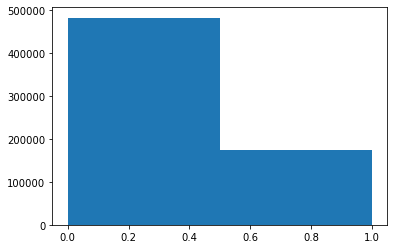

array([0, 1, 0, ..., 0, 0, 0], dtype=int32)

In [122]:
Xcb = weekMod.loc[weekMod['position']=='CB'][weekMod.columns[30:]].dropna()
xcbTrain = Xcb#.drop_duplicates()
scaler = MinMaxScaler()
scaler.fit(xcbTrain)
xcbTrainScaled = scaler.transform(xcbTrain)

km = KMeans(n_clusters=2)
km = km.fit(xcbTrainScaled)

pred_cb = km.predict(scaler.transform(Xcb))
plt.hist(pred_cb, bins=2)
#plt.savefig('kmeans_hist.png', dpi=300)
plt.show()
pred_cb

In [123]:
Xcb['clusterCB'] = pred_cb
weekFinCB = weekMod.join(Xcb[['clusterCB']]) 

In [121]:
Xcb.shape
Xcb.drop_duplicates().shape

(29219, 11)

In [117]:
pred_cb.shape

(29219,)

# Clustering - Safeties Man vs. Zone TODO

We start out with a knn model, evaluate it, do the same with a kmeans model, and then again with dbscan

In [91]:
Xs = weekMod.loc[(weekMod['position'].isin(['SS','FS','S']))][weekMod.columns[30:]].dropna()
 
# Note: weekMod is for week 1 rn
xsTrain = Xs.drop_duplicates()
scaler = MinMaxScaler()
scaler.fit(xsTrain)
xsTrainScaled = scaler.transform(xsTrain)

# Set and train the Gaussian mixture model
gmm_s = GaussianMixture(n_components=2, covariance_type='full', random_state=42)
gmm_s.fit(xsTrainScaled)

GaussianMixture(n_components=2, random_state=42)

In [66]:
abc = weekMod.loc[(weekMod['position'].isin(['SS','FS','S']))][weekMod.columns[30:]].dropna()
#abc[abc['position']=='FS'].head()
abc.head()

,varX,varY,varS,oppVar,oppMean,mateVar,mateMean,oppDirVar,oppDirMean,meanOppMateDistRatio,varOppMateDistRatio
1,0.000036,0.000189,0.000000,0.000025,1.918109,0.000972,5.882770,2637.883442,193.817273,0.290676,0.000005
3,0.003216,0.000187,0.001645,0.002955,4.912147,0.005817,4.013412,463.282687,63.215455,0.562519,0.000056
5,0.000125,0.000025,0.000027,0.000160,18.221115,0.000097,12.190637,44.362445,14.143636,1.903102,0.286890
15,0.000036,0.000189,0.000000,0.000025,1.918109,0.000972,5.882770,2637.883442,193.817273,0.290676,0.000005
17,0.003216,0.000187,0.001645,0.002955,4.912147,0.005817,4.013412,463.282687,63.215455,0.562519,0.000056


In [92]:
# Make class prediction and probability estimation
# #scaled training, so should also scale when predicting
# pred_cb = gmm_cb.predict(scaler.transform(Xcb))
# prob_cb = gmm_cb.predict_proba(scaler.transform(Xcb)) #predict all 
Accidentally pasted over this, will have to fix if we run it again
# # Join the class prediction and probability estimation into our main dataframe
# Xcb['clusterCB'] = pred_cb
# Xcb['clusterCB_prob'] = prob_cb[:,0]
# weekFinCB = weekMod.join(Xcb[['clusterCB', 'clusterCB_prob']]) 
#I think we'll have to append the other positions and their predictions to weekFinCB
#weekFinCB.columns.values
#weekFinCB.shape

(3401875, 45)

In [202]:
t = weekFinCB.loc[weekFinCB['position']=='CB']
print(f'shape of the resulting data: {t.shape}')
t.head()

shape of the resulting data: (657637, 43)


In [ ]:
weekFinS_CB.head()

### Now trying kmeans

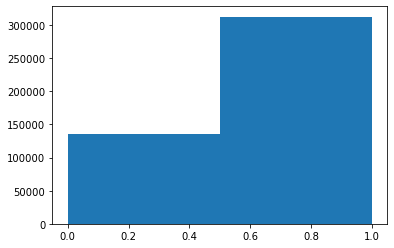

array([0, 1, 1, ..., 1, 1, 1], dtype=int32)

In [125]:
Xs = weekMod.loc[(weekMod['position'].isin(['SS','FS','S']))][weekMod.columns[30:]].dropna()
 
# Note: weekMod is for week 1 rn
xsTrain = Xs.drop_duplicates()
scaler = MinMaxScaler()
scaler.fit(xsTrain)
xsTrainScaled = scaler.transform(xsTrain)

km = KMeans(n_clusters=2)
km = km.fit(xsTrainScaled)


pred_s = km.predict(scaler.transform(Xs))
plt.hist(pred_s, bins=2)

Xs['clusterS'] = pred_s
weekFinS_CB = weekFinCB.join(Xs[['clusterS']]) 
#plt.savefig('kmeans_hist.png', dpi=300)
plt.show()
pred_s

In [ ]:
# Xs['clusterCB'] = pred_s
# weekFinCB = weekMod.join(Xs[['clusterCB']]) 

# Clustering - DB's Man vs. Zone 

We start out with a knn model, evaluate it, do the same with a kmeans model, and then again with dbscan

In [93]:
Xdb = weekMod.loc[weekMod['position']=='DB'][weekMod.columns[30:]].dropna()
 
# Note: weekMod is for week 1 rn
xdbTrain = Xdb.drop_duplicates()
scaler = MinMaxScaler()
scaler.fit(xdbTrain)
xdbTrainScaled = scaler.transform(xdbTrain)

# Set and train the Gaussian mixture model
gmm_db = GaussianMixture(n_components=2, covariance_type='full', random_state=42)
gmm_db.fit(xdbTrainScaled)

GaussianMixture(n_components=2, random_state=42)

In [94]:
# Make class prediction and probability estimation
#scaled training, so should also scale when predicting
pred_db = gmm_db.predict(scaler.transform(Xdb))
prob_db = gmm_db.predict_proba(scaler.transform(Xdb)) #predict all 
#pred_s = gmm_s.predict(Xs)
#prob_s = gmm_s.predict_proba(Xs) #predict all

# Join the class prediction and probability estimation into our main dataframe
Xdb['clustersDB'] = pred_db
Xdb['clustersDB_prob'] = prob_db[:,0]
weekFinS_CB_DB = weekFinS_CB.join(Xdb[['clustersDB', 'clustersDB_prob']]) 
#I think we'll have to append the other positions and their predictions to weekFinCB
#weekFinCB.columns.values
weekFinS_CB_DB.shape

(3401875, 47)

In [202]:
t = weekFinCB.loc[weekFinCB['position']=='CB']
print(f'shape of the resulting data: {t.shape}')
t.head()

shape of the resulting data: (657637, 43)


## Now trying kmeans

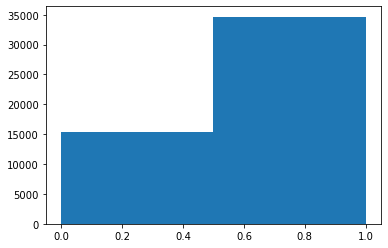

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

In [126]:
Xdb = weekMod.loc[weekMod['position']=='DB'][weekMod.columns[30:]].dropna()
 
# Note: weekMod is for week 1 rn
xdbTrain = Xdb.drop_duplicates()
scaler = MinMaxScaler()
scaler.fit(xdbTrain)
xdbTrainScaled = scaler.transform(xdbTrain)

km = KMeans(n_clusters=2)
km = km.fit(xdbTrainScaled)

pred_db = km.predict(scaler.transform(Xdb))
plt.hist(pred_db, bins=2)

Xdb['clustersDB'] = pred_db
weekFinS_CB_DB = weekFinS_CB.join(Xdb[['clustersDB']]) 
#plt.savefig('kmeans_hist.png', dpi=300)
plt.show()
pred_db

# Clustering - Linebackers Man vs. Zone TODO

We start out with a knn model, evaluate it, do the same with a kmeans model, and then again with dbscan

In [95]:
Xlb = weekMod.loc[(weekMod['position'].isin(['MLB','LB', 'OLB', 'ILB']))][weekMod.columns[30:]].dropna()

# Note: weekMod is for week 1 rn
xlbTrain = Xlb.drop_duplicates()
scaler = MinMaxScaler()
scaler.fit(xlbTrain)
xlbTrainScaled = scaler.transform(xlbTrain)

# Set and train the Gaussian mixture model
gmm_lb = GaussianMixture(n_components=2, covariance_type='full', random_state=42)
gmm_lb.fit(xdbTrainScaled)

GaussianMixture(n_components=2, random_state=42)

In [96]:
# Make class prediction and probability estimation
#scaled training, so should also scale when predicting
pred_lb = gmm_lb.predict(scaler.transform(Xlb))
prob_lb = gmm_lb.predict_proba(scaler.transform(Xlb)) #predict all 
#pred_s = gmm_s.predict(Xs)
#prob_s = gmm_s.predict_proba(Xs) #predict all

# Join the class prediction and probability estimation into our main dataframe
Xlb['clustersLB'] = pred_lb
Xlb['clustersLB_prob'] = prob_lb[:,0]
weekFinS_CB_DB_LB = weekFinS_CB_DB.join(Xlb[['clustersLB', 'clustersLB_prob']]) 
#I think we'll have to append the other positions and their predictions to weekFinCB
#weekFinCB.columns.values
weekFinS_CB_DB_LB.shape

(3401875, 49)

In [202]:
t = weekFinCB.loc[weekFinCB['position']=='CB']
print(f'shape of the resulting data: {t.shape}')
t.head()

shape of the resulting data: (657637, 43)


In [147]:
a = weekFinS_CB_DB_LB[(weekFinS_CB_DB_LB['position']=='S')]#.head(50)
a[3000:3400].head()

#Making sure that 1's and 0's are consistent - To check I watched the animations of a lot of different plays
# 1 -> zone, 0 -> man for db's 
# 1 -> man, 0 -> zone for cb's
# 1 -> man, 0 -> zone for lb's ? yes
# 1 -> zone, 0 -> man for safety's ? yes

# so swap the coverage classification for db's and safety's

,time,x,y,s,a,dis,o,dir,event,nflId,displayName,jerseyNumber,position,frameId,team,gameId,playId,playDirection,route,oppMinDist,closestOpp(nflId),oppDir,oppX,oppY,mateMinDist,closestMate(nflId),mateX,mateY,diffDir,oppMateDistRatio,varX,varY,varS,oppVar,oppMean,mateVar,mateMean,oppDirVar,oppDirMean,meanOppMateDistRatio,varOppMateDistRatio,clusterCB,clusterS,clustersDB,clustersLB
900180,2018-09-11T02:01:11.000Z,7.44,19.73,1.85,2.00,0.17,63.57,298.71,between_snap,2556617.0,Doug Middleton,36.0,S,19,away,2018091000,3415,left,NaN,12.329335,497326.0,279.89,19.01,15.47,7.121917,2543597.0,14.40,21.24,18.82,1.669407,2.814645,2.376119,0.843257,1.229245,12.739595,1.773447,8.276228,1541.40899,63.185517,1.48385,0.074637,NaN,1.0,NaN,NaN
900195,2018-09-11T02:01:11.099Z,7.27,19.83,2.10,1.99,0.20,61.16,303.74,between_snap,2556617.0,Doug Middleton,36.0,S,20,away,2018091000,3415,left,NaN,12.096289,497326.0,278.99,18.58,15.54,7.246551,2543597.0,14.37,21.28,24.75,1.699297,2.814645,2.376119,0.843257,1.229245,12.739595,1.773447,8.276228,1541.40899,63.185517,1.48385,0.074637,NaN,1.0,NaN,NaN
900210,2018-09-11T02:01:11.200Z,7.08,19.98,2.41,2.12,0.23,57.94,308.47,between_snap,2556617.0,Doug Middleton,36.0,S,21,away,2018091000,3415,left,NaN,11.890105,497326.0,276.85,18.13,15.59,7.376456,2543597.0,14.33,21.34,31.62,1.725152,2.814645,2.376119,0.843257,1.229245,12.739595,1.773447,8.276228,1541.40899,63.185517,1.48385,0.074637,NaN,1.0,NaN,NaN
900225,2018-09-11T02:01:11.299Z,6.89,20.14,2.63,1.92,0.25,56.61,311.33,between_snap,2556617.0,Doug Middleton,36.0,S,22,away,2018091000,3415,left,NaN,11.666949,497326.0,273.93,17.65,15.63,7.498333,2543597.0,14.28,21.41,37.40,1.743759,2.814645,2.376119,0.843257,1.229245,12.739595,1.773447,8.276228,1541.40899,63.185517,1.48385,0.074637,NaN,1.0,NaN,NaN
900240,2018-09-11T02:01:11.400Z,6.68,20.33,2.85,1.72,0.28,58.07,312.83,between_snap,2556617.0,Doug Middleton,36.0,S,23,away,2018091000,3415,left,NaN,11.494786,497326.0,268.18,17.17,15.63,7.628709,2543597.0,14.22,21.49,44.65,1.752081,2.814645,2.376119,0.843257,1.229245,12.739595,1.773447,8.276228,1541.40899,63.185517,1.48385,0.074637,NaN,1.0,NaN,NaN


## Now trying kmeans

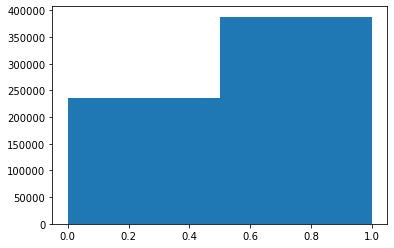

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

In [129]:
Xlb = weekMod.loc[(weekMod['position'].isin(['MLB','LB', 'OLB', 'ILB']))][weekMod.columns[30:]].dropna()

# Note: weekMod is for week 1 rn
xlbTrain = Xlb.drop_duplicates()
scaler = MinMaxScaler()
scaler.fit(xlbTrain)
xlbTrainScaled = scaler.transform(xlbTrain)

km = KMeans(n_clusters=2)
km = km.fit(xlbTrainScaled)

pred_lb = km.predict(scaler.transform(Xlb))
plt.hist(pred_lb, bins=2)

Xlb['clustersLB'] = pred_lb
weekFinS_CB_DB_LB =  weekFinS_CB_DB.join(Xlb['clustersLB']) 
#plt.savefig('kmeans_hist.png', dpi=300)
plt.show()
pred_lb

In [149]:
write_man_zone_to_csv = True
# features = [varX, varY, varS, oppVar, oppMean, mateVar, mateMean, oppDirVar, oppDirMean, oppMateDistRatioMean, oppMateDistRatioVar]
# for feature in features:
#     weekMod = pd.merge(weekMod, feature, how='left', on=['gameId', 'event', 'playId', 'nflId'])
    
if write_man_zone_to_csv:
    DATA_DIR = './data/raw'
    filename = 'player_manZone_ftGen_km_weeks1_2_5'
    #REDO classification but with kmeans and then save it here: 
    #filename = 'player_manZone_ftGen_km_weeks1_2_5'
    filepath = DATA_DIR + '/' + filename
    print(filepath)
    #print(.to_csv())
    weekFinS_CB_DB_LB.to_csv(filepath)


./data/raw/player_manZone_ftGen_km_weeks1_2_5


In [6]:
# import numpy as np
# import pandas as pd
# DATA_DIR = './data/raw'
# filename = DATA_DIR + '/player_manZone_ftGen_km_weeks1_2_5'
# a = pd.read_csv(filename)

In [8]:
# filename = DATA_DIR + '/player_manZone_ftGen_gm_weeks1_2_5'
# b = pd.read_csv(filename)

In [9]:
# b.head()

,Unnamed: 0,time,x,y,s,a,dis,o,dir,event,...,meanOppMateDistRatio,varOppMateDistRatio,clusterCB,clusterCB_prob,clusterS,clusterS_prob,clustersDB,clustersDB_prob,clustersLB,clustersLB_prob
0,0,2018-09-07T01:07:14.599Z,91.73,26.67,0.00,0.01,0.02,289.57,240.93,ball_snap,...,0.641170,4.278920e-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2018-09-07T01:07:14.599Z,88.89,36.47,0.01,0.01,0.01,105.63,66.66,ball_snap,...,0.290676,5.083461e-06,NaN,NaN,1.0,1.807102e-08,NaN,NaN,NaN,NaN
2,2,2018-09-07T01:07:14.599Z,91.35,44.16,0.02,0.03,0.01,290.45,16.86,ball_snap,...,0.742585,1.202835e-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,2018-09-07T01:07:14.599Z,86.31,22.01,0.09,0.42,0.01,70.12,168.91,ball_snap,...,0.562519,5.588078e-05,NaN,NaN,1.0,1.216969e-07,NaN,NaN,NaN,NaN
4,4,2018-09-07T01:07:14.599Z,90.78,36.15,0.00,0.00,0.00,257.61,193.97,ball_snap,...,0.238053,7.417441e-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# a.head()

,Unnamed: 0,time,x,y,s,a,dis,o,dir,event,...,mateVar,mateMean,oppDirVar,oppDirMean,meanOppMateDistRatio,varOppMateDistRatio,clusterCB,clusterS,clustersDB,clustersLB
0,0,2018-09-07T01:07:14.599Z,91.73,26.67,0.00,0.01,0.02,289.57,240.93,ball_snap,...,0.000046,3.393964,50.527362,199.977273,0.641170,4.278920e-07,NaN,NaN,NaN,NaN
1,1,2018-09-07T01:07:14.599Z,88.89,36.47,0.01,0.01,0.01,105.63,66.66,ball_snap,...,0.000972,5.882770,2637.883442,193.817273,0.290676,5.083461e-06,NaN,1.0,NaN,NaN
2,2,2018-09-07T01:07:14.599Z,91.35,44.16,0.02,0.03,0.01,290.45,16.86,ball_snap,...,0.000221,8.025493,1942.248702,110.977273,0.742585,1.202835e-05,NaN,NaN,NaN,NaN
3,3,2018-09-07T01:07:14.599Z,86.31,22.01,0.09,0.42,0.01,70.12,168.91,ball_snap,...,0.005817,4.013412,463.282687,63.215455,0.562519,5.588078e-05,NaN,0.0,NaN,NaN
4,4,2018-09-07T01:07:14.599Z,90.78,36.15,0.00,0.00,0.00,257.61,193.97,ball_snap,...,0.000221,8.025493,2637.883442,193.817273,0.238053,7.417441e-07,NaN,NaN,NaN,NaN


## Now, the predictions from the gaussian mixture model are saved in:
./data/raw/player_manZone_ftGen_gm_weeks1_2_5 
## and we don't have to run this code every time for them

#plot a man-man play

In [204]:
import src
from src.NFL_Data import NflData
DATA_DIR = './data/raw'
PLAY_DIR = DATA_DIR + '/plays.csv'
WEEK_DIR = DATA_DIR + '/games.csv'

playData = pd.read_csv(PLAY_DIR)
weekData = pd.read_csv(DATA_DIR + '/week1.csv')

In [206]:
import os
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.patches as patches

from src.plot_player_positions import PlayerPositionPlots

from ipywidgets import interact, fixed

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import animation
from matplotlib.animation import FFMpegWriter

from IPython.display import Video

/Users/bergtho/Desktop/stat451/working_proj/src/plot_player_positions.py:284: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/bergtho/Desktop/stat451/working_proj/src/plot_player_positions.py:285: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/bergtho/Desktop/stat451/working_proj/src/plot_player_positions.py:286: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation

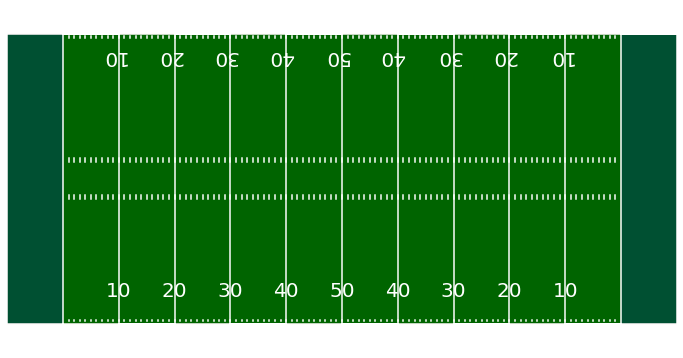

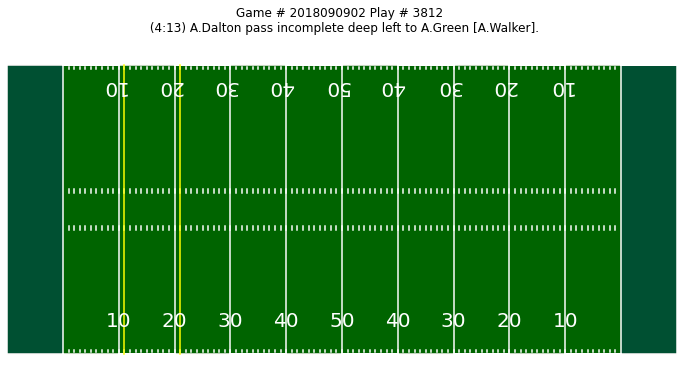

In [207]:
pplt = PlayerPositionPlots()
pplt.create_football_field()

anim = pplt.get_play_animation(weekData, playData)
writer = FFMpegWriter(fps=10)
anim_fp = os.getcwd() + '/animations/' + str(1) + '_' + str(3812) + '.mp4'

anim.save(anim_fp, writer)

Video(anim_fp, embed=True)

In [201]:
weekFinCB.shape

(3401875, 43)

In [ ]:
# km = KMeans(n_clusters=2, # 2 clusters -> 1 for man and one for pass
#            init='random',
#            n_init=10,
#            max_iter=10000,
#            random_state=0)
# y_km = km.fit_predict(xTrainScaled)
# Note: weekMod is for week 1 rn

X = weekMod.loc[weekMod['position']=='CB'][weekMod.columns[30:]].dropna()
xTrain = Xcb.drop_duplicates()
scaler = MinMaxScaler()
scaler.fit(xTrain)
xTrainScaled = scaler.transform(xTrain)

# Set and train the Gaussian mixture model
#gmm_cb = GaussianMixture(n_components=2, covariance_type='full', random_state=42)
#gmm_cb.fit(xcbTrainScaled)
Sum_of_squared_distances = []
K=range(1,10)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(xTrainScaled)
    Sum_of_squared_distances.append(km.inertia_)


plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.savefig('elbow_method_kmeans.png')
plt.show()

In [ ]:
km = KMeans(n_clusters=2)
km = km.fit(xTrainScaled)

y_km = km.fit_predict(xTrainScaled)
plt.hist(y_km, bins=2)
plt.savefig('kmeans_hist.png', dpi=300)
plt.show()
y_km

In [1]:
#xTrainScaled is the one to use

# from: https://www.kaggle.com/minc33/visualizing-high-dimensional-clusters
from sklearn.decomposition import PCA
import plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, \
plot, iplot

#PCA with one principal component
pca_1d = PCA(n_components=1)
PCs_1d = pd.DataFrame(pca_1d.fit_transform(pd.DataFrame(xTrainScaled).drop(["Cluster"], \
                                                      axis=1)))

#PCA with two principal components
pca_2d = PCA(n_components=2)
PCs_2d = pd.DataFrame(pca_2d.fit_transform(xTrainScaled.drop(["Cluster"], \
                                                      axis=1)))

#PCA with three principal components
pca_3d = PCA(n_components=3)
PCs_3d = pd.DataFrame(pca_3d.fit_transform(xTrainScaled.drop(["Cluster"], \
                                                      axis=1)))


In [177]:
DATA_DIR = './data/raw'

PLAY_DIR = DATA_DIR + '/plays.csv'

plays = pd.read_csv(PLAY_DIR)

In [179]:
plays.head()
# NOTE: we'll only have cb data for weeks 1,2, and 5 

,gameId,playId,playDescription,quarter,down,yardsToGo,possessionTeam,playType,yardlineSide,yardlineNumber,offenseFormation,personnelO,defendersInTheBox,numberOfPassRushers,personnelD,typeDropback,preSnapVisitorScore,preSnapHomeScore,gameClock,absoluteYardlineNumber,penaltyCodes,penaltyJerseyNumbers,passResult,offensePlayResult,playResult,epa,isDefensivePI
0,2018090600,75,(15:00) M.Ryan pass short right to J.Jones pus...,1,1,15,ATL,play_type_pass,ATL,20,I_FORM,"2 RB, 1 TE, 2 WR",7.0,4.0,"4 DL, 2 LB, 5 DB",TRADITIONAL,0.0,0.0,15:00:00,90.0,NaN,NaN,C,10,10,0.261827,False
1,2018090600,146,(13:10) M.Ryan pass incomplete short right to ...,1,1,10,ATL,play_type_pass,PHI,39,SINGLEBACK,"1 RB, 1 TE, 3 WR",7.0,4.0,"4 DL, 2 LB, 5 DB",TRADITIONAL,0.0,0.0,13:10:00,49.0,NaN,NaN,I,0,0,-0.372360,False
2,2018090600,168,(13:05) (Shotgun) M.Ryan pass incomplete short...,1,2,10,ATL,play_type_pass,PHI,39,SHOTGUN,"2 RB, 1 TE, 2 WR",6.0,4.0,"4 DL, 2 LB, 5 DB",TRADITIONAL,0.0,0.0,13:05:00,49.0,NaN,NaN,I,0,0,-0.702779,False
3,2018090600,190,(13:01) (Shotgun) M.Ryan pass deep left to J.J...,1,3,10,ATL,play_type_pass,PHI,39,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,5.0,"4 DL, 1 LB, 6 DB",SCRAMBLE_ROLLOUT_LEFT,0.0,0.0,13:01:00,49.0,NaN,NaN,C,33,33,3.047530,False
4,2018090600,256,(10:59) (Shotgun) M.Ryan pass incomplete short...,1,3,1,ATL,play_type_pass,PHI,1,SHOTGUN,"2 RB, 3 TE, 0 WR",8.0,6.0,"6 DL, 3 LB, 2 DB",TRADITIONAL,0.0,0.0,10:59:00,11.0,NaN,NaN,I,0,0,-0.842272,False


array(['time', 'x', 'y', 's', 'a', 'dis', 'o', 'dir', 'event', 'nflId',
       'displayName', 'jerseyNumber', 'position', 'frameId', 'team',
       'gameId', 'playId', 'playDirection', 'route', 'oppMinDist',
       'closestOpp(nflId)', 'oppDir', 'oppX', 'oppY', 'mateMinDist',
       'closestMate(nflId)', 'mateX', 'mateY', 'diffDir',
       'oppMateDistRatio', 'varX', 'varY', 'varS', 'oppVar', 'oppMean',
       'mateVar', 'mateMean', 'oppDirVar', 'oppDirMean',
       'meanOppMateDistRatio', 'varOppMateDistRatio', 'clusterCB',
       'clusterCB_prob'], dtype=object)

In [134]:
exp = weekFinCB.dropna()
a = exp.groupby(['gameId', 'playId', 'nflId']).head()
#a['clusterCB'].shape
len(a)

0

In [ ]:
a = pd.dataframe(cols=['x','y','id'])
for i in range(10):
    a.append([i,(2*i),i])
    
# so the expected value should be 1
 





 # Clustering - Safety Man vs. Zone

In [108]:
Xs = weekMod.loc[(weekMod['position'].isin(['SS','FS','S']))][weekMod.columns[30:]].dropna()
# TODO: classify these - also should we put db's in this one or classify them on their own?
 
# Note: weekMod is for week 1 rn
xsTrain = Xs.drop_duplicates()
scaler = MinMaxScaler()
scaler.fit(xsTrain)
xsTrainScaled = scaler.transform(xsTrain)

# Set and train the Gaussian mixture model
gmm_s = GaussianMixture(n_components=2, covariance_type='full', random_state=42)
gmm_s.fit(xsTrainScaled)

GaussianMixture(n_components=2, random_state=42)

In [109]:
# Make class prediction and probability estimation
#scaled training, so should also scale when predicting
pred_s = gmm_s.predict(scaler.transform(Xs))
prob_s = gmm_s.predict_proba(scaler.transform(Xs)) #predict all 
#pred_s = gmm_s.predict(Xs)
#prob_s = gmm_s.predict_proba(Xs) #predict all

# Join the class prediction and probability estimation into our main dataframe
Xs['clusterS'] = pred_s
Xs['clusterS_prob'] = prob_s[:,0]
weekFinS_CB = weekFinCB.join(Xs[['clusterS', 'clusterS_prob']]) 
#I think we'll have to append the other positions and their predictions to weekFinCB
#weekFinCB.columns.values
weekFinS_CB.shape

(986022, 45)

In [105]:
#weekFinS.columns.values
#weekFinS.isnull().sum()
#weekFinCB.isnull().sum()
#weekFinCB.join(Xs[['clusterS', 'clusterS_prob']])
#weekFinS['clusterS'].unique()

array([nan,  1.,  0.])

# Clustering - db man vs. zone

In [110]:
Xdb = weekMod.loc[weekMod['position']=='DB'][weekMod.columns[30:]].dropna()

# TODO: classify these - also should we put db's in this one or classify them on their own?
 
# Note: weekMod is for week 1 rn
xdbTrain = Xdb.drop_duplicates()
scaler = MinMaxScaler()
scaler.fit(xdbTrain)
xdbTrainScaled = scaler.transform(xdbTrain)

# Set and train the Gaussian mixture model
gmm_db = GaussianMixture(n_components=2, covariance_type='full', random_state=42)
gmm_db.fit(xdbTrainScaled)

GaussianMixture(n_components=2, random_state=42)

In [111]:
# Make class prediction and probability estimation
#scaled training, so should also scale when predicting
pred_db = gmm_db.predict(scaler.transform(Xdb))
prob_db = gmm_db.predict_proba(scaler.transform(Xdb)) #predict all 
#pred_s = gmm_s.predict(Xs)
#prob_s = gmm_s.predict_proba(Xs) #predict all

# Join the class prediction and probability estimation into our main dataframe
Xdb['clustersDB'] = pred_db
Xdb['clustersDB_prob'] = prob_db[:,0]
weekFinS_CB_DB = weekFinS_CB.join(Xdb[['clustersDB', 'clustersDB_prob']]) 
#I think we'll have to append the other positions and their predictions to weekFinCB
#weekFinCB.columns.values
weekFinS_CB_DB.shape

(986022, 47)

# Clustering - linebacker man vs. zone

In [114]:
Xlb = weekMod.loc[(weekMod['position'].isin(['MLB','LB', 'OLB', 'ILB']))][weekMod.columns[30:]].dropna()

# Note: weekMod is for week 1 rn
xlbTrain = Xlb.drop_duplicates()
scaler = MinMaxScaler()
scaler.fit(xlbTrain)
xlbTrainScaled = scaler.transform(xlbTrain)

# Set and train the Gaussian mixture model
gmm_lb = GaussianMixture(n_components=2, covariance_type='full', random_state=42)
gmm_lb.fit(xdbTrainScaled)

GaussianMixture(n_components=2, random_state=42)

In [115]:
# Make class prediction and probability estimation
#scaled training, so should also scale when predicting
pred_lb = gmm_lb.predict(scaler.transform(Xlb))
prob_lb = gmm_lb.predict_proba(scaler.transform(Xlb)) #predict all 
#pred_s = gmm_s.predict(Xs)
#prob_s = gmm_s.predict_proba(Xs) #predict all

# Join the class prediction and probability estimation into our main dataframe
Xlb['clustersLB'] = pred_lb
Xlb['clustersLB_prob'] = prob_lb[:,0]
weekFinS_CB_DB_LB = weekFinS_CB_DB.join(Xlb[['clustersLB', 'clustersLB_prob']]) 
#I think we'll have to append the other positions and their predictions to weekFinCB
#weekFinCB.columns.values
weekFinS_CB_DB_LB.shape

(986022, 49)

# Done running the model on the data. 

Now we have all of the data fitted to a model, however it's time-series data, and since we're short on time for this presentation, I'll just get the average zone/man probability for each player in each play, and store it in a new dataframe called gmm_player_play_coverages with columns (num_cb_zone, num_cb_m2m, num_s_zone, num_s_m2m, num_db_zone, num_db_m2m). 

that with columns:

playId
cb2


oppMean = weekMod.groupby(['gameId', 'playId', 'event', 'nflId'])['oppMinDist'].agg(['mean']).reset_index().rename(columns={"mean": "oppMean"})


To summarize: we're making a new df for the results of the gaussian model, with unique identifier [gameId', 'playId', 'event', 'nflId'])

In [ ]:
#read in the plays dataframe (can be normal or from)

In [ ]:
# Goal: 
# df with all cornerbacks, aggregate and take the mean 

Now that we have our data scaled and it is usable, we'll plot it before running a classifier on it

In [143]:
# df.columns
# names = xTrain.columns.values
# scatterplotmatrix(xTrain)
# plt.tight_layout()
# plt.show()

In [161]:
from sklearn.metrics import silhouette_samples
from matplotlib import cm

In [162]:
def silhouette_plot(X, y_km):
    # TODO: follow the code from the kmeans_ex, from prof's book
    cluster_labels = np.unique(y_km)
    n_clusters = cluster_labels.shape[0]
    silhouette_vals = silhouette_samples(X, y_km, metric='euclidean')
    y_ax_lower, y_ax_upper = 0, 0
    yticks = []
    for i, c in enumerate(cluster_labels):
        c_silhouette_vals = silhouette_vals[y_km == c]
        c_silhouette_vals.sort()
        y_ax_upper += len(c_silhouette_vals)
        color = cm.jet(float(i) / n_clusters)
        plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0, 
                 edgecolor='none', color=color)

        yticks.append((y_ax_lower + y_ax_upper) / 2.)
        y_ax_lower += len(c_silhouette_vals)

    silhouette_avg = np.mean(silhouette_vals)
    plt.axvline(silhouette_avg, color="red", linestyle="--") 

    plt.yticks(yticks, cluster_labels + 1)
    plt.ylabel('Cluster')
    plt.xlabel('Silhouette coefficient')

    plt.tight_layout()
    #plt.savefig('images/11_04.png', dpi=300)
    plt.show()

In [166]:
def histogram_plot_of_classification(X, y_m, num_bins):
    plt.hist(y_m, bins=num_bins)
    #return "not implemented"

# kmeans

In [163]:
from sklearn.cluster import KMeans

In [164]:
km = KMeans(n_clusters=2, # 2 clusters -> 1 for man and one for pass
           init='random',
           n_init=10,
           max_iter=10000,
           random_state=0)
y_km = km.fit_predict(xTrainScaled)
plt.hist(y_km, bins=2)

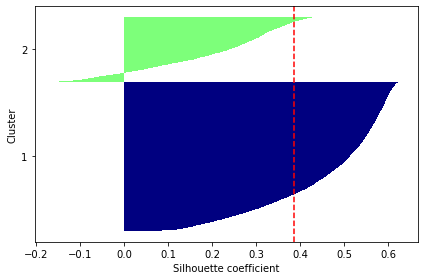

In [165]:
silhouette_plot(xTrainScaled, y_km)

(array([5972., 2584.]), array([0. , 0.5, 1. ]), <a list of 2 Patch objects>)

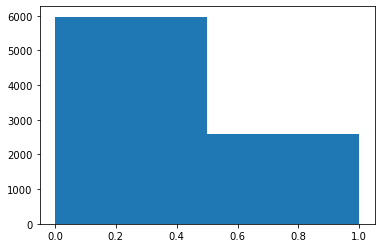

In [167]:
plt.hist(y_km, bins=2)

In [170]:
y_km

array([0, 1, 0, ..., 1, 0, 1], dtype=int32)

# can use the csv below to evaluate if it classifies the coverage right or not 
stat451/working_proj/data/raw/coverages_week1.csv
(I got this data from: https://www.kaggle.com/tombliss/additional-data-coverage-schemes-for-week-1 and thought it would be a good idea to only run classification on week 1 so we can check if the results are kind of right or not)


positions to make a classifier for: 'SS', 'FS', 'MLB', 'CB', 'LB', 'OLB', 'ILB', 'DB', 'DL','NT', 'S', 'DE'

## Safety Coverage Classification

In [3]:
# Xs = weekMod.loc[(weekMod['position'].isin(['SS','FS','S']))][weekMod.columns[30:]].dropna()


,varX,varY,varS,oppVar,oppMean,mateVar,mateMean,oppDirVar,oppDirMean,meanOppMateDistRatio,varOppMateDistRatio
1,0.000036,0.000189,0.000000,0.000025,1.918109,0.000972,5.882770,2637.883442,193.817273,0.290676,0.000005
15,0.000036,0.000189,0.000000,0.000025,1.918109,0.000972,5.882770,2637.883442,193.817273,0.290676,0.000005
29,0.000036,0.000189,0.000000,0.000025,1.918109,0.000972,5.882770,2637.883442,193.817273,0.290676,0.000005
43,0.000036,0.000189,0.000000,0.000025,1.918109,0.000972,5.882770,2637.883442,193.817273,0.290676,0.000005
57,0.000036,0.000189,0.000000,0.000025,1.918109,0.000972,5.882770,2637.883442,193.817273,0.290676,0.000005
...,...,...,...,...,...,...,...,...,...,...,...
985990,4.825613,3.195425,2.946383,7.387544,4.646112,5.305397,4.275220,9753.260261,117.056000,4.285052,7.803512
986002,0.277126,34.902151,1.649024,2.218413,2.991775,11.420737,5.478244,23325.734304,159.538750,0.517298,0.068297
986005,4.825613,3.195425,2.946383,7.387544,4.646112,5.305397,4.275220,9753.260261,117.056000,4.285052,7.803512
986017,0.277126,34.902151,1.649024,2.218413,2.991775,11.420737,5.478244,23325.734304,159.538750,0.517298,0.068297


# Defensive back coverage classification

In [177]:
Xdb = weekMod.loc[weekMod['position']=='DB'][weekMod.columns[30:]].dropna()

# now analyzing linebacker coverages

In [178]:
Xlb = weekMod.loc[(weekMod['position'].isin(['MLB','LB', 'OLB', 'ILB']))][weekMod.columns[30:]].dropna()
